In [ ]:
import sys
sys.path.append("/sdf/group/ad/beamphysics/jytang/cavity_genesis4_20keV/cavity_genesis4") 
from genesis4.lume_genesis_JT import Genesis4
from genesis4.lume_genesis_JT.plot import plot_stats
import numpy as np
import matplotlib.pyplot as plt
import os
from constants import *
import logging
logging.getLogger('matplotlib.font_manager').disabled = True


## Load archive

In [17]:
basedir = '/sdf/data/ad/ard/u/jytang/cavity_genesis4_20keV/data_qgrad0_8_5kA'
# basedir = './run3_moreheater/'
files = np.array(os.listdir(basedir))
files = files[np.array(['K' in file for file in files])]
files = files[np.array(['n15' in file for file in files])]

files = files[np.array(['taper0.0' in file for file in files])]

files = files[np.array(['.out.h5'    in file for file in files])]

#files = files[np.array(['h5'   in file for file in files])]
#files = files[np.array(['Run2'   in file for file in files])]

files = files[np.array(['fld'  not in file for file in files])]
files = files[np.array(['lat'  not in file for file in files])]
files = files[np.array(['beam'  not in file for file in files])]
print(files)
files = files[np.array(['in'  not in file for file in files])]
files = files[np.array(['par'  not in file for file in files])]
#files = files[np.array(['out'  not in file for file in files])]
files = files[np.array(['err'  not in file for file in files])]
files = np.sort(files)
files



['K0.4335_taper0.01_n15.out.h5']


array(['K0.4335_taper0.01_n15.out.h5'], dtype='<U36')

In [18]:

Glist = []
for file in files:
    print(file)
    G = Genesis4(workdir = basedir, use_temp_dir = False)
    G.load_archive(basedir + '/' + file)
    Glist.append(G)

K0.4335_taper0.01_n15.out.h5


OSError: Unable to synchronously open file (file signature not found)

In [9]:
G.output_info()

Output data

key                       value              unit
--------------------------------------------------
Beam/LSCfield             array: (4289, 9600)  eV/m
Beam/SSCfield             array: (4289, 9600)  eV/m
Beam/alphax               array: (1, 9600)   rad
Beam/alphay               array: (1, 9600)   rad
Beam/betax                array: (1, 9600)   m
Beam/betay                array: (1, 9600)   m
Beam/bunching             array: (4289, 9600)  
Beam/bunchingphase        array: (4289, 9600)  rad
Beam/current              array: (4289, 9600)  A
Beam/efield               array: (4289, 9600)  eV/m
Beam/emax                 array: (4289, 9600)  m_ec^2
Beam/emin                 array: (4289, 9600)  m_ec^2
Beam/emitx                array: (1, 9600)   m
Beam/emity                array: (1, 9600)   m
Beam/energy               array: (4289, 9600)  m_ec^2
Beam/energyspread         array: (4289, 9600)  m_ec^2
Beam/pxmax                array: (4289, 9600)  rad
Beam/pxmin                arr

In [10]:
gam0 = G.output['Global/gamma0']
xlamds = G.output['Global/lambdaref']
zsep = G.output['Global/sample']
dgird = G.output['Field/dgrid']
ncar = G.output['Field/ngrid']
h_Plank = H_PLANK;      # Plank constant [eV-sec]
c_speed  = CSPEED;           # speed of light[m/sec]
hw0 = h_Plank * c_speed / xlamds
dt = xlamds*zsep/c_speed

0.428735835


(0.428735835, 0.43393349999999997)

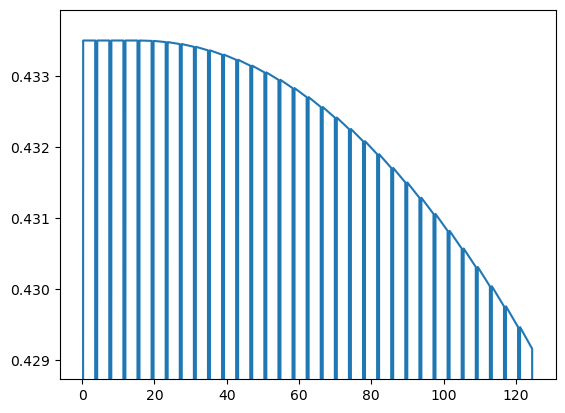

In [11]:
amx = 0
amin =  float('inf')
for G in Glist:
    z = G.output['Lattice/z']
    aw = G.output['Lattice/aw']
    amx = np.amax((amx,np.amax(aw[aw>0])))
    amx += amx * 1e-3
    amin = np.amin((amin,np.amin(aw[aw>0])))
    amin -= amin*1e-3
    plt.plot(z, aw)
print(amin)
plt.ylim([amin, amx])

## Plot profile of ebeam

Text(0, 0.5, 'energy(MeV)')

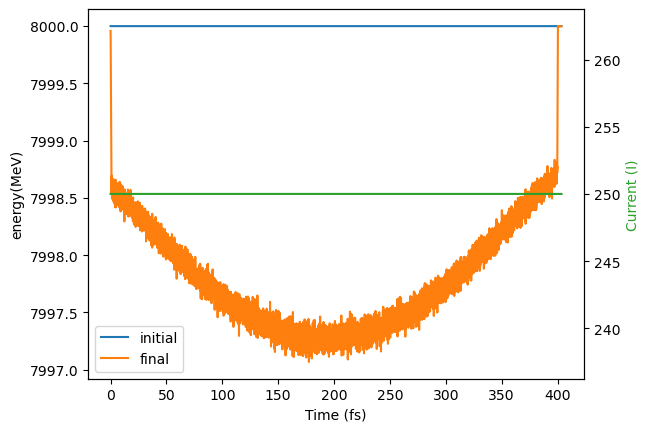

In [12]:
energy_init = G.output['Beam/energy'][0, :]
energy_final = G.output['Beam/energy'][-1,:]
current = G.output['Beam/current']
currlist = current[0,:]
s = G.output['Global/s']
plt.plot(s/3e8*1e15, energy_init*0.511, color = 'C0', label = 'initial')
plt.plot(s/3e8*1e15, energy_final*0.511, color = 'C1', label = 'final')
plt.legend()
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(s/3e8*1e15, currlist, color = 'C2')
ax.set_xlabel('Time (fs)')
ax2.set_ylabel('Current (I)', color = 'C2')
ax.set_ylabel('energy(MeV)')

## Plot Power Gain

Text(0, 0.5, 'power')

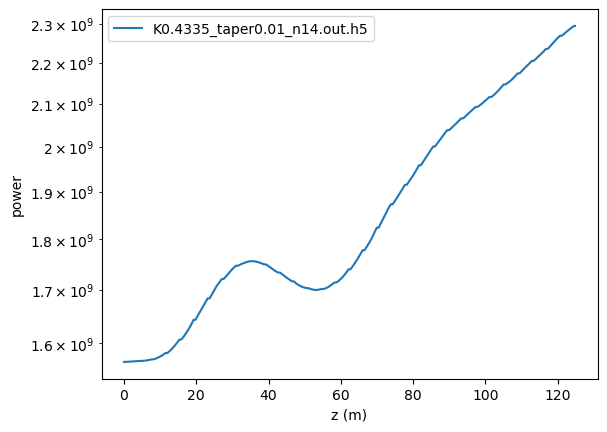

In [13]:
num_photon_list = []
for count, G in enumerate(Glist):
    z = G.output['Lattice/zplot']
    label = G.output['outfile'].split('/')[-1]
    power = np.amax(G.output['Field/power'], axis = 1)
    energy = np.sum(G.output['Field/power'], axis = 1)*dt
    num_photon = energy/(hw0*1.60218e-19)
    num_photon_list.append(num_photon[-1])
    plt.plot(z, power, label = label)
    plt.yscale('log')
plt.legend()
plt.xlabel('z (m)')
#plt.ylabel('Number of photons')
plt.ylabel('power')

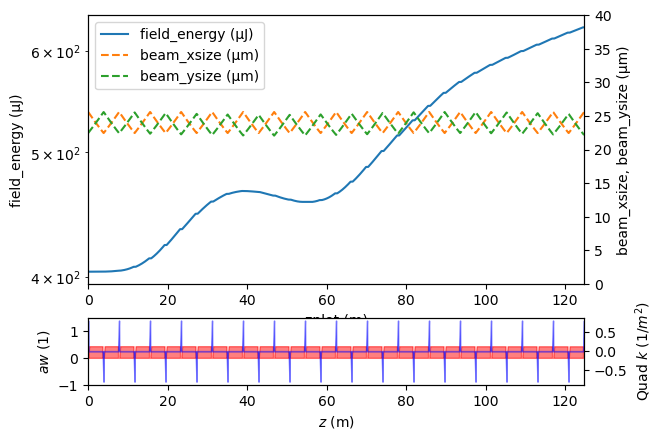

In [14]:
G.plot('field_energy', yscale='log', y2 = ['beam_xsize', 'beam_ysize'], ylim2=(0, 40e-6))

## Plot Power Profile

In [15]:
G.output['Field/power'].shape

(4289, 9600)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


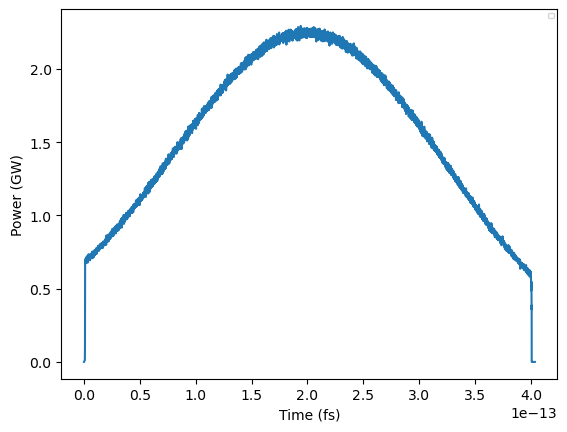

In [16]:
for count, G in enumerate(Glist):
    s = G.output['Global/s']
    label = G.output['outfile'].split('/')[0]
    intensity = G.output['Field/power'][-1,:]
    plt.plot(s/3e8, intensity/1e9, label = label)
    break
    #plt.yscale('log')
    #ax = plt.gca()
    #ax2 = ax.twinx()
    #ax2.plot(s/3e8, phase)
plt.xlabel('Time (fs)')
plt.ylabel('Power (GW)')
plt.legend(fontsize = 5)

## Plot spectrum

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


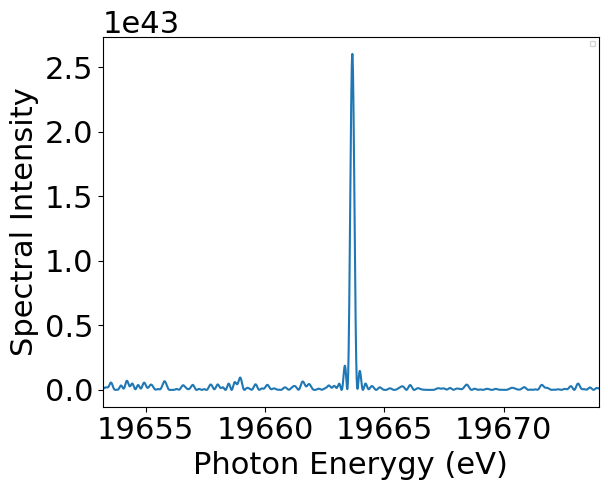

In [182]:
for count, G in enumerate(Glist):
    s = G.output['Global/s']
    label = G.output['outfile'].split('/')[-1]
    intensity = G.output['Field/intensity-nearfield'][-1,:]
    phase = G.output['Field/phase-nearfield'][-1, :]
    

    h_Plank = 4.135667696e-15
    npad = 10000
    cspeed = 299792458
    nslice = intensity.shape[0]
    
    nslice_padded = nslice + 2*npad
    s = np.arange(nslice)*dt
    s2 = np.arange(nslice_padded) * dt
    s_fs2 = s2*1e15
    hw0_eV = h_Plank * cspeed / xlamds
    Dhw_eV = h_Plank / dt 
    hws = hw0_eV + Dhw_eV / 2. * np.linspace(-1.,1., nslice_padded)

    central = intensity *np.exp(1j*phase)
    central_padded = np.pad(central, (npad, npad))
    ftfld = np.fft.fftshift(np.fft.fft(central_padded))
    spectrum = np.abs(ftfld)**2
    plt.plot(hws, spectrum)
    plt.xlabel('Photon Enerygy (eV)')
    plt.ylabel('Spectral Intensity')
    plt.xlim([19653.2, 19674])
    plt.legend(fontsize = 5)

## Load field

In [98]:
import h5py
from genesis4.lume_genesis_JT.readers import load_genesis4_fields
from recirculation.plot_fld import * 

norm = 15872561719227.826     energy = 667.7  uJ    t , y  mean = 0.2 fs , -0.1 um      t , y  rms = 5.7 fs , 38.5 um     wt , wy = 11.4 fs , 77.0 um     t , y  fwhm = nan fs , nan um


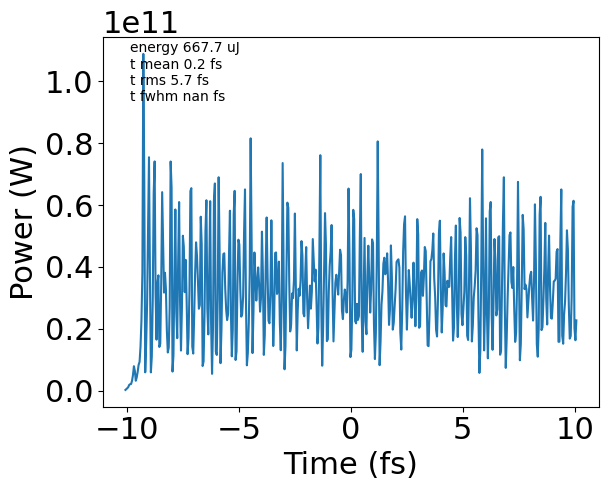

norm = 15872561719227.826     energy = 667.7  uJ    x , y  mean = 0.0 um , -0.1 um      x , y  rms = 35.6 um , 34.9 um     wx , wy = 71.2 um , 69.8 um     x , y  fwhm = nan um , nan um


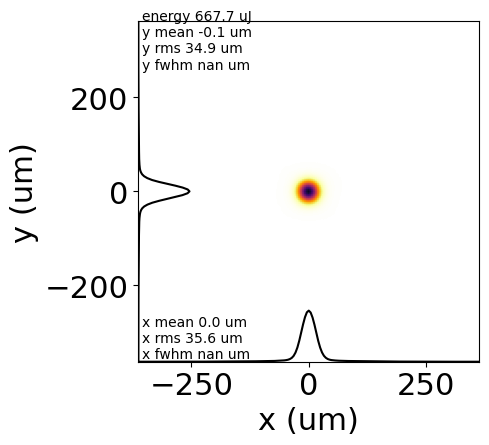

In [267]:
fld_filename = '/sdf/data/ad/ard/u/jytang/cavity_genesis4_20keV/data_qgrad1_5_5kA/K0.4335_taper0.01_n4.fld.h5'
with h5py.File(fld_filename, 'r') as h5:
    dfl, param = load_genesis4_fields(h5)
c_speed = 299792458
dt = param['slicespacing']/c_speed
plot_fld_power(dfl, dt, ax=None, saveFilename=None, showPlotQ=True, savePlotQ=True, logScaleQ=False)
plot_fld_marginalize_t(dfl, dgrid = param['gridsize']*param['gridpoints']/2, dt=dt, saveFilename=None, showPlotQ=True, savePlotQ=True)

norm = 4642909717854.017     energy = 195.3  uJ    t , y  mean = -30.4 fs , -0.0 um      t , y  rms = 258.7 fs , 27.0 um     wt , wy = 517.4 fs , 54.0 um     t , y  fwhm = nan fs , nan um


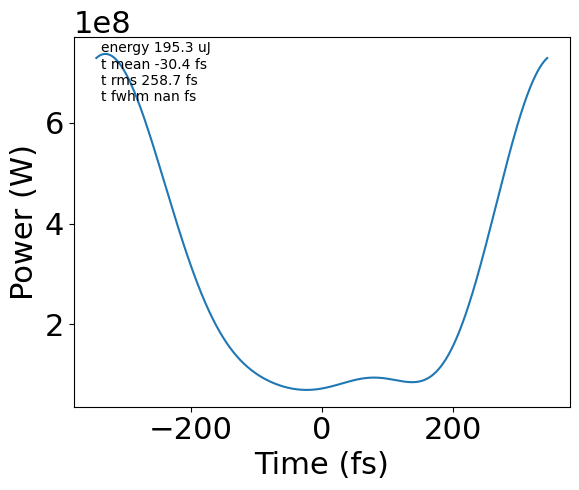

norm = 4642909717854.021     energy = 195.3  uJ    x , y  mean = 6.2 um , -0.0 um      x , y  rms = 67.2 um , 24.5 um     wx , wy = 134.4 um , 49.0 um     x , y  fwhm = nan um , nan um


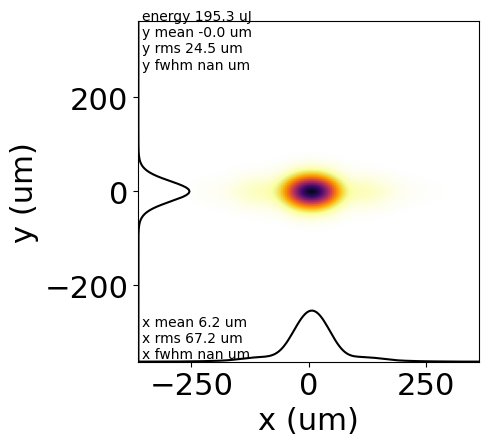

In [272]:
fld_filename = '/sdf/data/ad/ard/u/jytang/cavity_genesis4_20keV/data_qgrad0_8_5kA/n10_seed_init.fld.h5'
with h5py.File(fld_filename, 'r') as h5:
    dfl, param = load_genesis4_fields(h5)
c_speed = 299792458
dt = param['slicespacing']/c_speed
plot_fld_power(dfl, dt, ax=None, saveFilename=None, showPlotQ=True, savePlotQ=True, logScaleQ=False)
plot_fld_marginalize_t(dfl, dgrid = param['gridsize']*param['gridpoints']/2, dt=dt, saveFilename=None, showPlotQ=True, savePlotQ=True)

## Plot spectrum from field

In [239]:
cspeed =299792458
h_Plank = 4.135667696e-15
npad = 20000
xlamds = param['wavelength']
nslice = dfl.shape[2]
ncar = dfl.shape[0]
nslice_padded = nslice + 2*npad
s = np.arange(nslice)*dt
s2 = np.arange(nslice_padded) * dt
s_fs2 = s2*1e15
hw0_eV = h_Plank * cspeed / xlamds
Dhw_eV = h_Plank / dt 
hws = hw0_eV + Dhw_eV / 2. * np.linspace(-1.,1., nslice_padded)

central = dfl[ncar//2,  ncar//2, :]
central_padded = np.pad(central, (npad, npad))
ftfld = np.fft.fftshift(np.fft.fft(central_padded))
spectrum = np.abs(ftfld)**2

(19653.0, 19664.5)

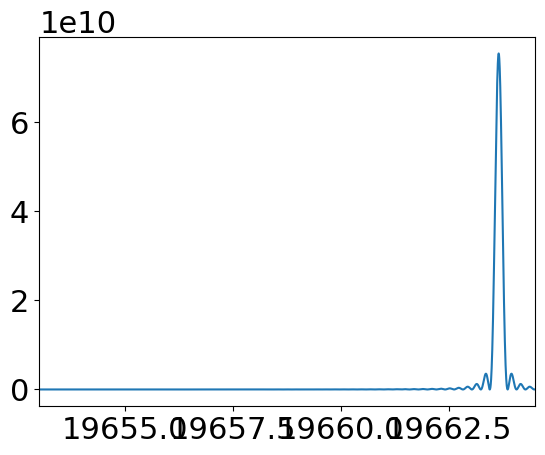

In [240]:
plt.plot(hws, spectrum)
plt.xlim([19653, 19664.5])
#plt.xlim([19600, 19690])

In [ ]:
from genesis.version4 import parsers, writers, readers
import h5py
cspeed =299792458
h_Plank = 4.135667696e-15
npad = 10000
spectrum_list = []

for count, G in enumerate(Glist):
    ncar = int(G.output['Field/ngrid'])
    dgrid = G.output['Field/dgrid']
    xlamds = G.output['Global/lambdaref']
    sample = G.output['Global/sample']
    dt = xlamds*sample/cspeed

    #phase_nearfield = G.output['Field/phase-nearfield'][-1, :]
    #intensity_nearfield = G.output['Field/intensity-nearfield'][-1, :]
    G.load_fields()
    dfl = G.field[files[count]]['dfl']
    param = G.field[files[count]]['param']
    
    #central = dfl[ncar//2 +1, ncar//2 + 1, :]
    nslice = dfl.shape[2]
    nslice_padded = nslice + 2*npad
    s = np.arange(nslice)*dt
    s2 = np.arange(nslice_padded) * dt
    s_fs2 = s2*1e15
    hw0_eV = h_Plank * cspeed / xlamds
    Dhw_eV = h_Plank / dt 
    hws = hw0_eV + Dhw_eV / 2. * np.linspace(-1.,1., nslice_padded)

    central_padded = np.pad(dfl, ((0,0), (0,0),(npad, npad)))
    ftfld = np.fft.fftshift(np.fft.fft(central_padded, axis = 2), axes = 2)
    spectrum = np.sum(np.abs(ftfld)**2, axis = (0, 1))

    spectrum_list.append((hws,spectrum))

In [ ]:
count = 0
spec_ave = np.zeros(spectrum_list[0][1].shape)
for hws, spec in spectrum_list:
    plt.plot(hws, spec, label = files[count], alpha = 1.0)
    plt.xlim([9828,9835])
    plt.xlabel('Photon energy (eV)')
    count += 1
    spec_ave += spec
    #plt.legend()
spec_ave /= (count + 1)
#plt.plot(hws, spec_ave, color = 'k')

In [222]:
import pickle
pickle.dump((hws, spec_ave, spectrum_list), open( "./data/stage2/chirp40.p", "wb" ) )

In [193]:
## Get photon number within 100meV
ind_peak = np.argmax(spec_ave)
hws0 = hws[ind_peak]
ind = (hws < hws0 + 0.05)&(hws > hws0 - 0.05)
np.sum(spec[ind])/np.sum(spec)*np.sum(num_photon_list)/5/1e6

50.242637289085934

In [ ]:
[50e6, ]

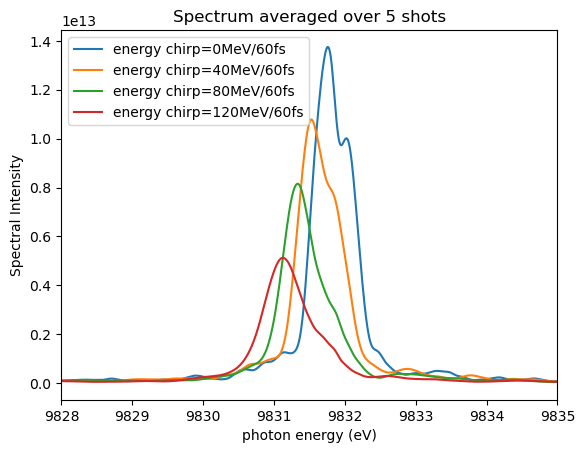

In [227]:
for chirp in [0, 40, 80, 120]:
    data = pickle.load( open("./data/stage2/chirp" + str(chirp)+".p", "rb" ) )
    hws = data[0]
    spec_av = data[1]
    plt.plot(hws, spec_av, label = 'energy chirp=' + str(chirp) +'MeV/60fs')
    plt.xlim([9828,9835])
    plt.xlabel('photon energy (eV)')
    plt.ylabel('Spectral Intensity')
    plt.title('Spectrum averaged over 5 shots')
    plt.legend()

## 2D plots

In [26]:
def make_zs_plot(pdat, zlist, slist_fs, currlist, energylist_init, energylist_fin, ax = None, label = ''):
    if not ax:
        fig, ax = plt.subplots()
    
    currlist_scaled = currlist - 0*np.min(currlist)
    currlist_scaled /= np.max(currlist_scaled)
    currlist_scaled *= np.max(zlist) - np.min(zlist)
    currlist_scaled += np.min(zlist)
    energylist_init_scaled = energylist_init - np.min(energylist_fin)
    energylist_init_scaled /= np.max(energylist_init_scaled)
    energylist_init_scaled *= np.max(zlist) - np.min(zlist)
    energylist_init_scaled += np.min(zlist)
    energylist_fin_scaled = energylist_fin - np.min(energylist_fin)
    energylist_fin_scaled /= np.max(energylist_fin_scaled)
    energylist_fin_scaled *= np.max(zlist) - np.min(zlist)
    energylist_fin_scaled += np.min(zlist)
    
    #pdat = np.reshape(np.array(outputdat.iloc[:,ia]), [int(outputdat.shape[0] / len(zlist)), len(zlist)]).T
    im = ax.imshow(pdat, interpolation = 'none', extent = [slist_fs[0], slist_fs[-1], zlist[0], zlist[-1]], origin = 'lower', aspect = 0.75*(slist_fs[-1] - slist_fs[0]) / (zlist[-1] - zlist[0]))
    ax.set_xlabel('$s$ (fs)')
    ax.set_ylabel('$z$ (m)')

    cbar = fig.colorbar(im, ax = ax)
    cbar.set_label(label, rotation = 270)
    ax.plot(slist_fs, currlist_scaled, 'w', alpha = 0.5, scalex = False, scaley = False);
    ax.plot(slist_fs, energylist_init_scaled, '#ff9900', alpha = 0.5, scalex = False, scaley = False);
    ax.plot(slist_fs, energylist_fin_scaled, '#ff9900', alpha = 0.25, scalex = False, scaley = False);

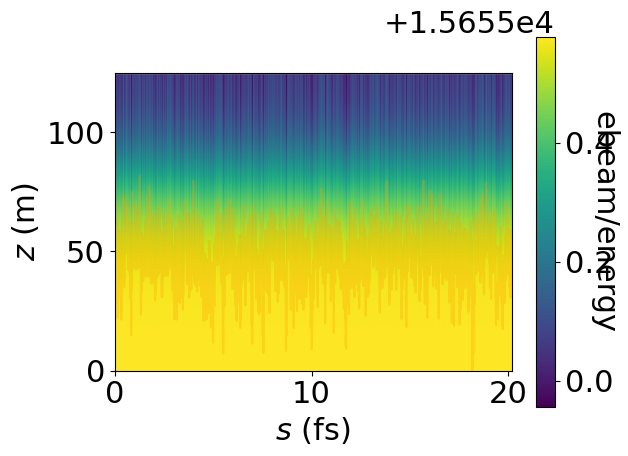

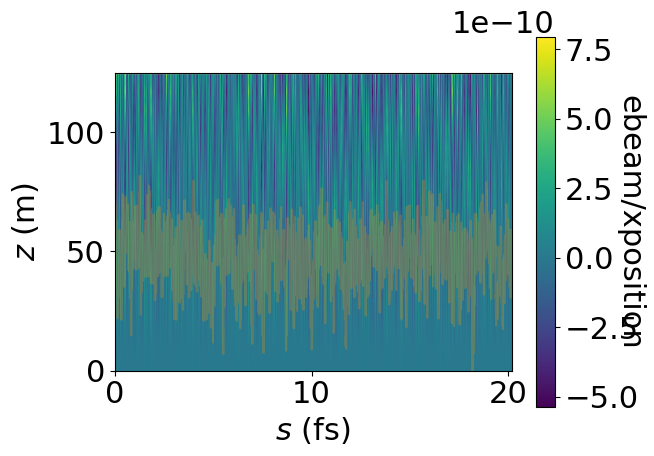

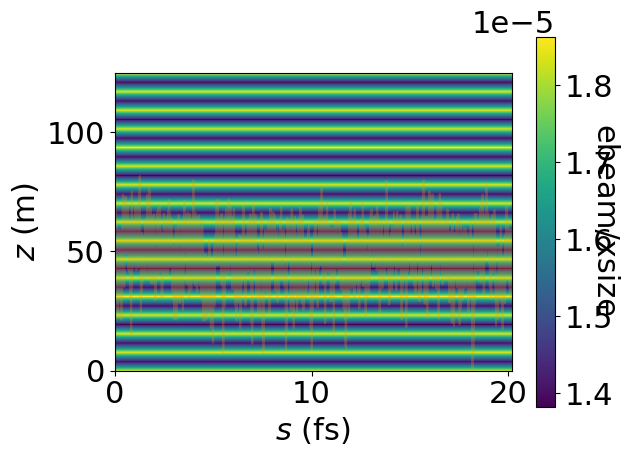

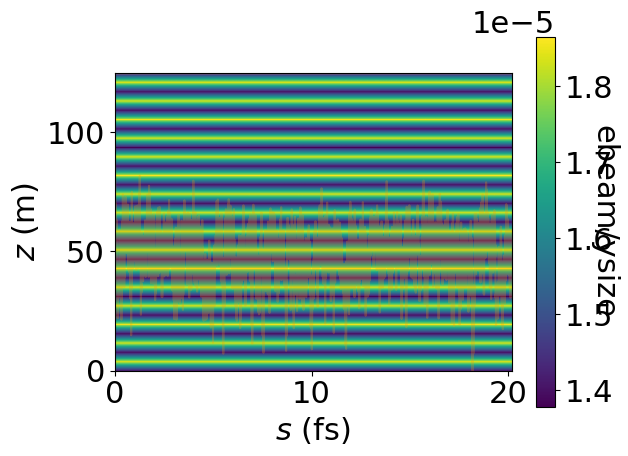

In [27]:
zlist = G.output['Lattice/zplot']
slist_fs = G.output['Global/s']/3e8*1e15
beam_energy = G.output['Beam/energy']
make_zs_plot(pdat = beam_energy, zlist = zlist, slist_fs = slist_fs, currlist = currlist, 
             energylist_init = energy_init, energylist_fin = energy_final, label = 'ebeam/energy')

beam_xposition =G.output['Beam/xposition']

make_zs_plot(pdat =beam_xposition, zlist = zlist, slist_fs = slist_fs, currlist = currlist, 
             energylist_init = energy_init, energylist_fin = energy_final, label = 'ebeam/xposition')

beam_yposition = G.output['Beam/yposition']
beam_xsize = G.output['Beam/xsize']
make_zs_plot(pdat =beam_xsize, zlist = zlist, slist_fs = slist_fs, currlist = currlist, 
             energylist_init = energy_init, energylist_fin = energy_final, label = 'ebeam/xsize')

beam_ysize = G.output['Beam/ysize']
make_zs_plot(pdat =beam_ysize, zlist = zlist, slist_fs = slist_fs, currlist = currlist, 
             energylist_init = energy_init, energylist_fin = energy_final, label = 'ebeam/ysize')
beam_bunching = G.output['Beam/bunching']
field_xsize = G.output['Field/xsize']
field_ysize = G.output['Field/ysize']

## Plot Spectrum

In [43]:
from genesis.version4 import parsers, writers, readers
import h5py
angle_list = []
spectrum_list = []
for count, G in enumerate(Glist):
    print(count)
    filename = './output_phase_10keV/K1.172_taper0.0_b' + str(detune[count]) + '.fld.h5'
    with h5py.File(filename, "r") as h5:
        dfl, param = readers.load_genesis4_fields(h5)
    cspeed =299792458
    h_Plank = 4.135667696e-15
    npad = 10000
    ncar = param['gridpoints']
    dgrid = param['gridsize']
    xlamds = param['wavelength']
    dt = param['slicespacing']/cspeed
    nslice = dfl.shape[2]
    central = dfl[ncar//2+1, ncar//2+1, :] 
    phase = np.angle(central)
    nslice_padded = nslice + 2*npad
    s = np.arange(nslice)*dt
    s2 = np.arange(nslice_padded) * dt
    s_fs2 = s2*1e15
    hw0_eV = h_Plank * cspeed / xlamds
    Dhw_eV = h_Plank / dt 
    hws = hw0_eV + Dhw_eV / 2. * np.linspace(-1.,1., nslice_padded)

    central_padded = np.pad(central, (npad, npad))
    ftfld = np.fft.fftshift(np.fft.fft(central_padded, axis = 0), axes = 0)
    spectrum = np.abs(ftfld)**2\

    angle_list.append(phase)
    spectrum_list.append(spectrum)
    
    plt.plot(hws, np.abs(ftfld)**2)
    plt.xlim([9827, 9835])

0


NameError: name 'detune' is not defined

Text(0, 0.5, 'phase shift')

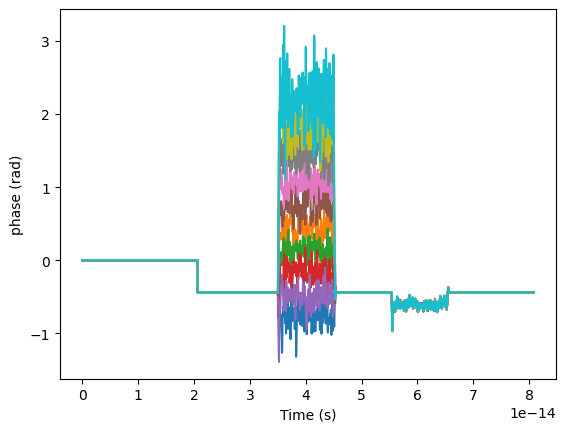

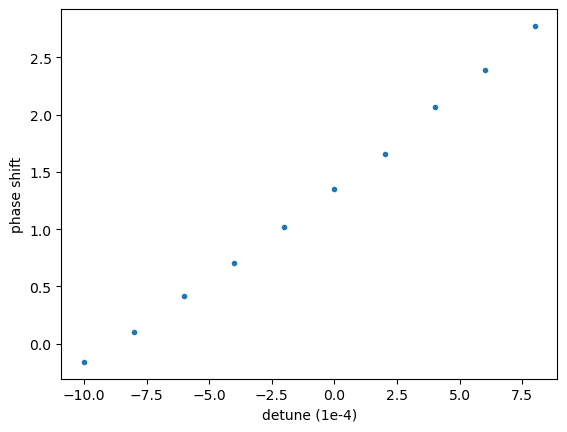

In [40]:
dphase = []
for count, phase in enumerate(angle_list):
    plt.figure(1)
    plt.plot(s, np.unwrap(phase))
    phase1 = np.mean(phase[(s>35e-15)&(s<45e-15)])
    phase2 = np.mean(phase[(s>55e-15)&(s<65e-15)])
    dphase.append(phase1 - phase2)

plt.xlabel('Time (s)')
plt.ylabel('phase (rad)')
plt.figure(2)
plt.plot(detune, dphase, '.')
plt.xlabel('detune (1e-4)')
plt.ylabel('phase shift')

In [ ]:
cspeed =299792458
h_Plank = 4.135667696e-15
npad = 1000

keys = sorted(G.field.keys())[0]
dfl = G.field[keys]['dfl']
nslice = dfl.shape[2]
param = G.field[keys]['param']
ncar = param['gridpoints']
dgrid = param['gridsize']
xlamds = param['wavelength']
dt = param['slicespacing']/cspeed

central = dfl[ncar//2+1, ncar//2+1, :] 
nslice_padded = nslice + 2*npad
s2 = np.arange(nslice_padded) * dt
s_fs2 = s2*1e15
hw0_eV = h_Plank * cspeed / xlamds
Dhw_eV = h_Plank / dt 
hws = hw0_eV + Dhw_eV / 2. * np.linspace(-1.,1., nslice_padded)

central_padded = np.pad(central, (npad, npad))
ftfld = np.fft.fftshift(np.fft.fft(central_padded, axis = 0), axes = 0)

plt.plot(hws, np.abs(ftfld)**2)
plt.xlim([1470, 1520])

In [15]:
np.random.randint(1,3, size = 10)

array([1, 1, 2, 1, 2, 2, 2, 2, 2, 1])

Text(0, 0.5, 'power after filtering')

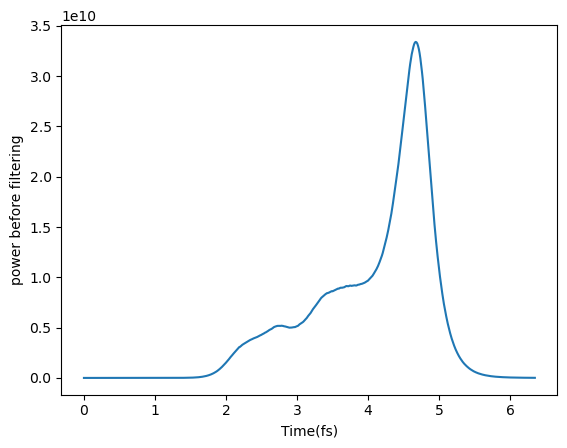

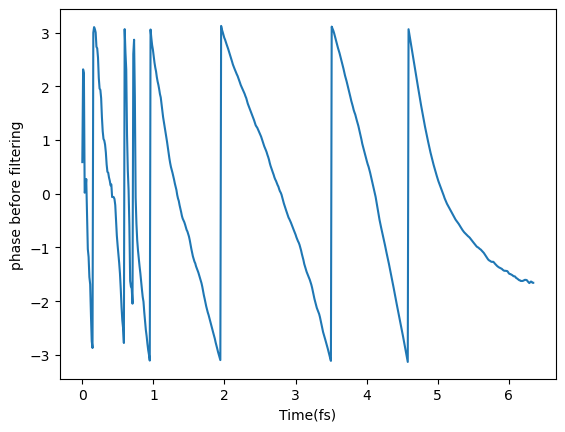

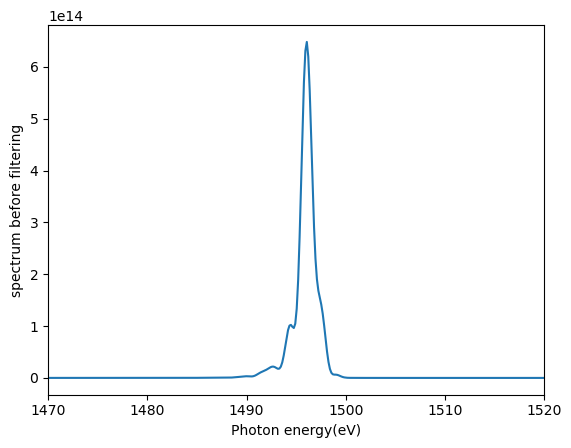

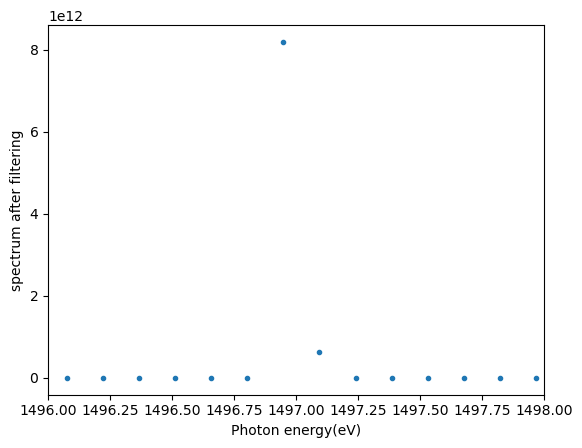

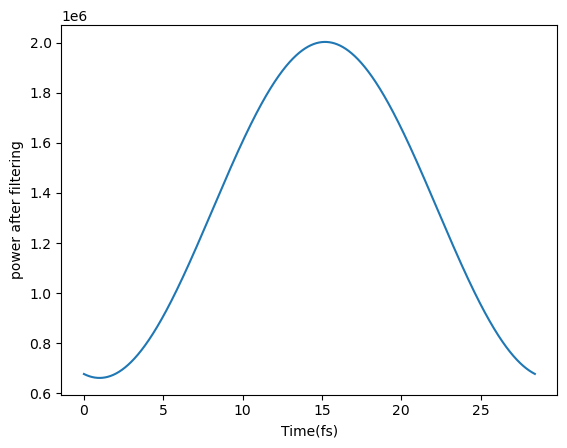

In [9]:

cspeed =299792458
h_Plank = 4.135667696e-15
npad = 1000
mask_center_eV = 1497

keys = sorted(G.field.keys())[0]
dfl = G.field[keys]['dfl']
nslice = dfl.shape[2]
param = G.field[keys]['param']
ncar = param['gridpoints']
dgrid = param['gridsize']
xlamds = param['wavelength']
dt = param['slicespacing']/cspeed

central = dfl[ncar//2+1, ncar//2+1, :] 
nslice_padded = nslice + 2*npad

s = np.arange(nslice) * dt
s_fs = s*1e15
s2 = np.arange(nslice_padded) * dt
s_fs2 = s2*1e15
hw0_eV = h_Plank * cspeed / xlamds
Dhw_eV = h_Plank / dt 
hws = hw0_eV + Dhw_eV / 2. * np.linspace(-1.,1., nslice_padded)


dfl_padded = np.pad(dfl, ( (0,0), (0,0), (npad, npad)))
ftfld = np.fft.fftshift(np.fft.fft(dfl_padded, axis = 2), axes = 2)


plt.figure(1)
plt.plot(s_fs, np.sum(np.abs(dfl )**2, axis = (0,1)))
plt.xlabel('Time(fs)')
plt.ylabel('power before filtering') 


plt.figure(2)
plt.plot(s_fs, np.angle(dfl[ncar//2 + 1, ncar//2+1, :] ))
plt.xlabel('Time(fs)')
plt.ylabel('phase before filtering') 
#plt.xlim([40,50])

plt.figure(3)
plt.plot(hws, np.sum(np.abs(ftfld)**2, axis = (0,1)) )
#plt.xlim([590,610])
plt.xlabel('Photon energy(eV)')
plt.ylabel('spectrum before filtering') 
plt.xlim([1470, 1520])


plt.figure(4)
mask_width_eV = 0.12/2.355
mask_eff = np.sqrt(0.1)
mask = mask_eff*np.exp(-1/2*(hws - mask_center_eV)**2/mask_width_eV**2)
ftfld_fltr = ftfld*mask[ np.newaxis, np.newaxis, :]
plt.plot(hws, np.sum(np.abs(ftfld_fltr)**2, axis = (0,1)),'.')
#plt.plot(hws,np.sum(np.abs(ftfld)**2, axis = (1,2)),'.')
plt.xlim([mask_center_eV-1, mask_center_eV+1])
plt.xlabel('Photon energy(eV)')
plt.ylabel('spectrum after filtering')

field_fltr = np.fft.ifft(np.fft.ifftshift(ftfld_fltr, axes = 2), axis = 2)
power = np.sum(np.abs(field_fltr )**2, axis = (0,1))
plt.figure(5)
plt.plot(s_fs2, power)
plt.xlabel('Time(fs)')
plt.ylabel('power after filtering') 



In [10]:
param['slicecount'] += npad*2

In [11]:
param

{'gridpoints': 301,
 'gridsize': 1.3333333333333333e-05,
 'refposition': 0.0,
 'wavelength': 8.27e-10,
 'slicecount': 2576,
 'slicespacing': 3.308e-09}

In [13]:
import h5py
with h5py.File("./output/seed"+str(count)+".h5", "w") as f:
    for key in param:
        f.create_dataset(key, data = [param[key]])
    for i in range(field_fltr.shape[2]):
        key = 'slice' + "{:06d}".format(i)
        g = f.create_group(key)
        g.create_dataset('field-real', data = np.real(field_fltr[:,:, i].flatten()))
        g.create_dataset('field-imag', data = np.imag(field_fltr[:,:, i].flatten()))

In [15]:
i

2575

In [15]:
G.output_info()

Output data

key                       value              unit
--------------------------------------------------
Beam/alphax               array: (1, 512)    rad
Beam/alphay               array: (1, 512)    rad
Beam/betax                array: (1, 512)    m
Beam/betay                array: (1, 512)    m
Beam/bunching             array: (1351, 512)  
Beam/bunchingphase        array: (1351, 512)  rad
Beam/current              array: (1, 512)    A
Beam/efield               array: (1351, 512)  eV/m
Beam/emitx                array: (1, 512)    m
Beam/emity                array: (1, 512)    m
Beam/energy               array: (1351, 512)  
Beam/energyspread         array: (1351, 512)  
Beam/pxposition           array: (1351, 512)  rad
Beam/pyposition           array: (1351, 512)  rad
Beam/xposition            array: (1351, 512)  m
Beam/xsize                array: (1351, 512)  m
Beam/yposition            array: (1351, 512)  m
Beam/ysize                array: (1351, 512)  m
Field/dgrid        

In [136]:
pulselen = 80e-15
sigma = 5e-15
peak_current = 2.0e3
NPTS = 1000
cspeed  = 299792458
SLEN = pulselen*cspeed
sigma_z = sigma*cspeed

S = np.linspace(0, SLEN, NPTS)

CURRENT = np.ones((NPTS,))*peak_current
CURRENT[S > SLEN/2 + sigma_z] = 0
CURRENT[S < SLEN/2 - sigma_z] = 0

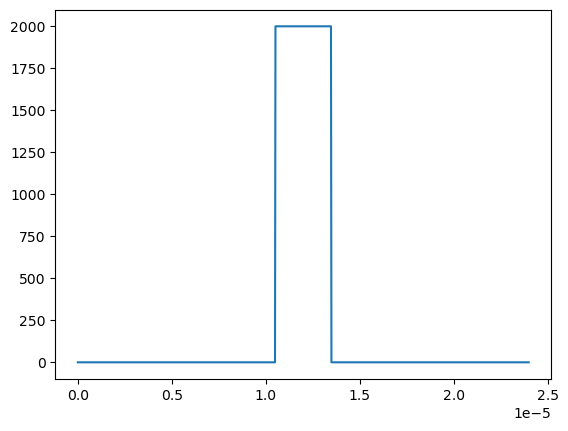

In [137]:
plt.plot(S, CURRENT)

In [7]:
import numpy as np
xlamds = (1.55e-9)/3
xlamdu = 0.039
gam0 = np.around(3990./0.511,3)
np.sqrt(xlamds/xlamdu*2*gam0**2-1)

0.7844736939534364